In [9]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from auto_robot_design.optimization.saver import (ProblemSaver)
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L,get_preset_by_index

In [10]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [11]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.075, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1,
                                                                                   ground_symmetric_step2,
                                                                                   ground_symmetric_step3,
                                                                                   central_vertical,
                                                                                   left_vertical,
                                                                                   right_vertical])

# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)

reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

reward_manager.add_trajectory_aggregator([0, 1, 2], 'mean')
reward_manager.add_trajectory_aggregator([3, 4, 5], 'mean')

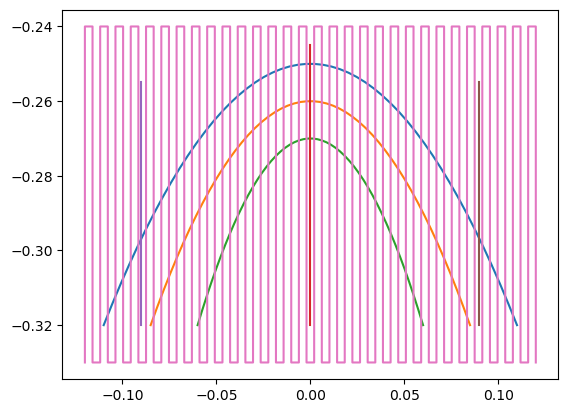

In [12]:
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [14]:
gm = get_preset_by_index(0)
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

population_size = 64
n_generations = 10

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, f"first_setup\\topology_{0}", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       64 |      4 |             - |             -
     2 |      128 |      4 |  0.2492543621 |             f
     3 |      192 |      3 |  0.1775711056 |         ideal
     4 |      256 |      7 |  0.3022109457 |         ideal
     5 |      320 |      8 |  0.1779041670 |         ideal
     6 |      384 |     11 |  0.0190352358 |             f
     7 |      448 |     13 |  0.0989782035 |         ideal
     8 |      512 |     11 |  0.0288875390 |         ideal
     9 |      576 |     13 |  0.0187252206 |             f
    10 |      640 |     10 |  0.0035492941 |             f


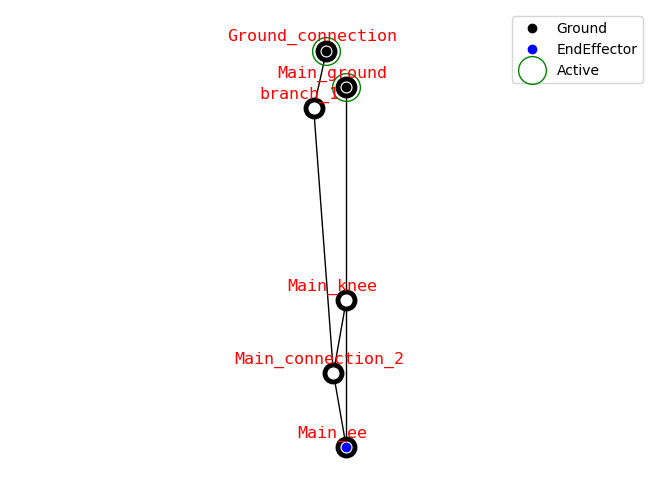

In [15]:
path = saver.path
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.4, 0.6])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)
plt.savefig(os.path.join(path, f'weights_04_06'))

In [17]:
len(res.X)

10

In [19]:
res.Fs

AttributeError: 'Result' object has no attribute 'Fs'

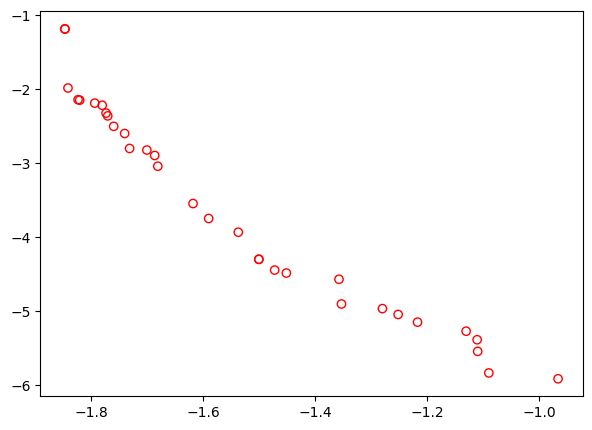

In [ ]:
F = res.F
xl, xu = problem.bounds()
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, )
ax.scatter(F[:, 0], F[:, 1],  facecolors='none', edgecolors='r')